<a href="https://colab.research.google.com/github/bianca-andreeadraganescu/PIU_Game2022/blob/main/Copy_of_p4_w2_disparity_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 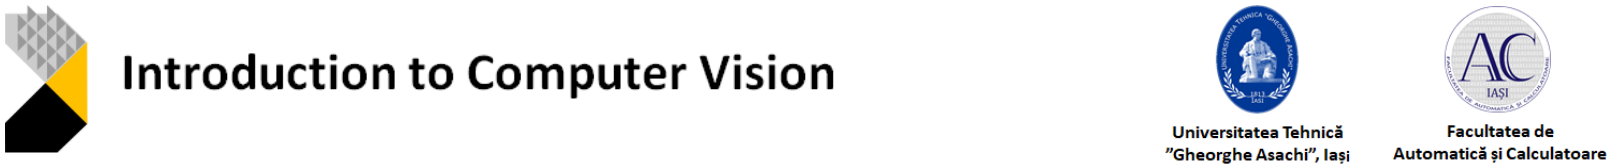

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs. 
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 4: Obstacles detection based on disparity maps

## Week 2: Obstacle and ground detection based on disparity maps

**UV-isparity maps**

In order to extract the regions of interest (obstacle regions)
we will use the UV-disparity space. UV-disparity space is computed
from disparity map.

**A brief recap before moving on**

We saw that if we have two images of same scene, we can get depth information from that in an intuitive way. Below is an image and some simple mathematical formulas which proves that intuition.
<figure>
<center>
<img src='https://docs.opencv.org/3.1.0/stereo_depth.jpg' />
</center>
</figure>

The above diagram contains equivalent triangles. Writing their equivalent equations will yield us following result:

$$disparity=x−x′=\frac{Bf}{Z}$$
$x$ and $x′$ are the distance between points in image plane corresponding to the scene point 3D and their camera center. $B$ is the distance between two cameras (which we know) and $f$ is the focal length of camera (already known). So in short, above equation says that the $depth$ of a point in a scene is inversely proportional to the difference in distance of corresponding image points and their camera centers. So with this information, we can derive the depth of all pixels in an image. [text source: docs.opencv.org/4.2.0/ ]

**UV-disparity space**

After the disparity map is computed, we have to compute
the UV-disparity space.

*U-disparity* space is a column based matrix which stores
the same disparity values for every column from disparity map. 

$$u_{id} = \sum_{j = 0}^{rows}\delta_{ij}, \delta_{ij} = \{ ^{ 1, disp_{ij} = d}_{0, otherwise} , $$ 
where $u_{id}$ represents the value from U-disparity space which
cumulates the number of pixels with disparity $d$ from column $i$
in the disparity map. 

Same as *U-disparity* space, *V-disparity* space is a row based matrix which stores the disparity values for every column from disparity map.

$$v_{dj} = \sum_{i = 0}^{cols}\delta_{ij}, \delta_{ij} = \{ ^{ 1, disp_{ij} = d}_{0, otherwise} , $$ 

where $v_{dj}$ represents the value from V-disparity space which
cumulates the number of pixels with disparity $d$ from row $j$ in
the disparity map.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1Bjq3ySr1t-w_2SHILZxlsxHBWOQeXjcg' />
<figcaption>UV-disparity space example</figcaption></center>
</figure>


For more details see: [UV disparity based obstacle detection and pedestrian
classification in urban traffic scenarios](http://users.utcluj.ro/~igiosan/Resources/Papers/UV%20disparity%20based%20obstacle%20detection%20and%20pedestrian%20classification%20in%20urban%20traffic%20scenarios.pdf), A. Iloie, I. Giosan, S. Nedevschi, Computer Science Department, Technical University of Cluj-Napoca, Romania


### UV-disparity computation

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

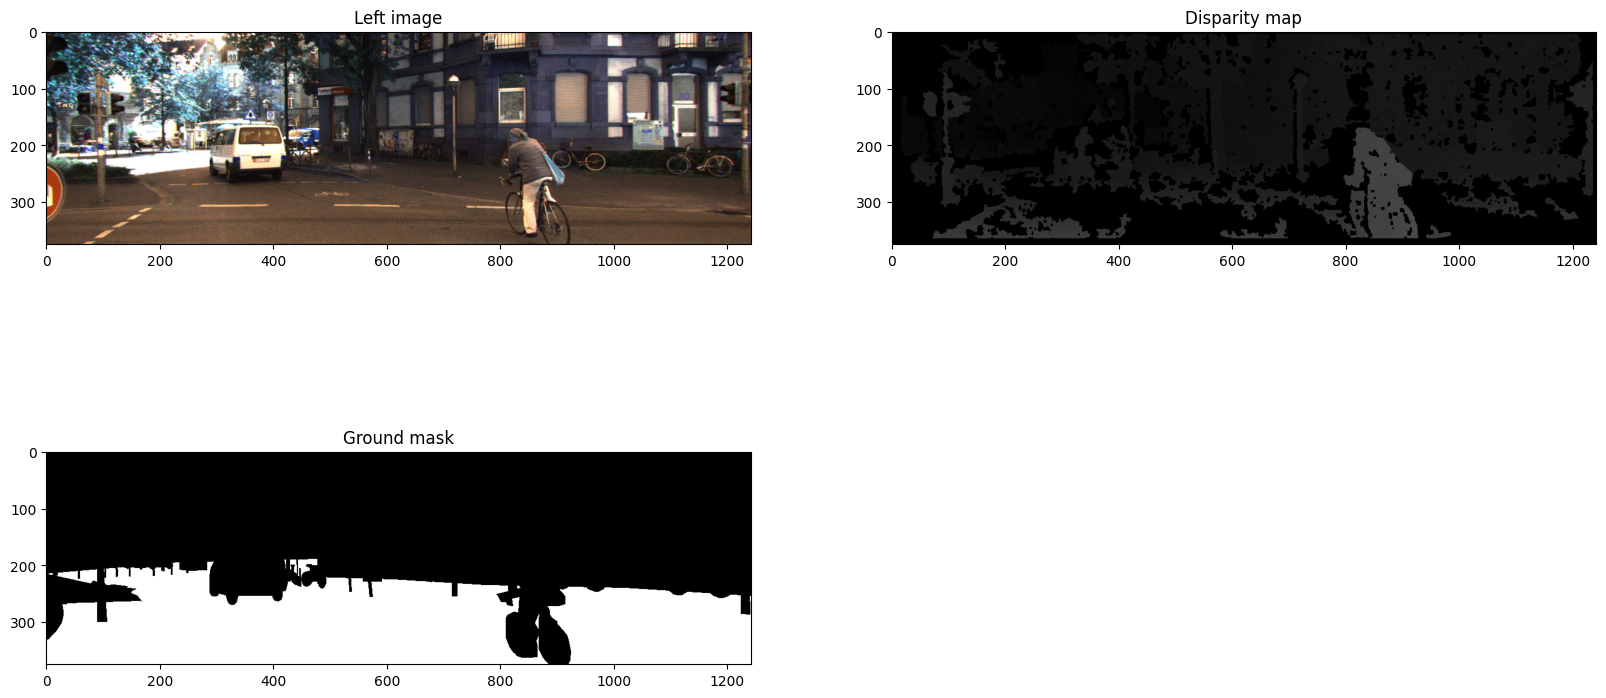

In [6]:
#TO DO: 
#(1) load the left image
#(2) load the disparity 
#(3) load the ground mask
#(4) display the 3 images

# https://drive.google.com/drive/folders/1ZMtcUS0AuaCsKDCm46SWsxtkXsHGaiSU?usp=sharing
dataset_path = '/content/drive/MyDrive/sva/KITTI/'
left_img = cv2.imread(dataset_path + '/left/000002_10.png')
right_img = cv2.imread(dataset_path + '/right/000002_10.png')
disparity = cv2.imread(dataset_path + '/disparity/000002_10.png')
groundMask = cv2.imread(dataset_path + '/ground/000002_10.png')

fig = plt.figure(figsize=(20, 10))
im1 = fig.add_subplot(2,2,1)
im1.set_title('Left image')
im1.imshow(left_img)

im2 = fig.add_subplot(2,2,2)
im2.set_title('Disparity map')
im2.imshow(disparity, 'gray')

im3 = fig.add_subplot(2,2,3)
im3.set_title('Ground mask')
im3.imshow(groundMask, 'gray')

plt.show()

#### Object detection using U-disparity maps

In [14]:
#Steps to compute the U-disparity map
#TO DO:
#(1) using the ground mask, remove ground pixels from the disparity map
#(2) determine the U-Disparity height by computing the max value from the disparity map (computed at (1))
#(3) compute U-disparity map using the formula from above

def uDisparity(disparity, groundMask):
  dim = disparity.shape
  h = dim[0]
  w = dim[1]
  # clone the disparity image
  newDisparity = np.copy(disparity)

  # remove ground pixels
  newDisparity[groundMask] = 0
  nonZeroMask = np.greater(newDisparity, 0)

  # Remove ground pixels
  newDisparity[groundMask == 1] = 0

  # Compute the maximum disparity value
  udispHeight = np.max(newDisparity)

  # Create a zero matrix to store the U-disparity
  udisp = np.zeros((udispHeight, w), dtype=np.uint8)
  for i in range(h):
      for j in range(w):
          if newDisparity[i, j].any() > 0:
              udisp[newDisparity[i, j]-1, j] += 1


  return udisp, udispHeight

In [15]:
#function that assign a color for each distinct region
#code source: https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    return labeled_img

In [16]:
#compute U-disparity
udisp, udispHeight = uDisparity(disparity, groundMask)

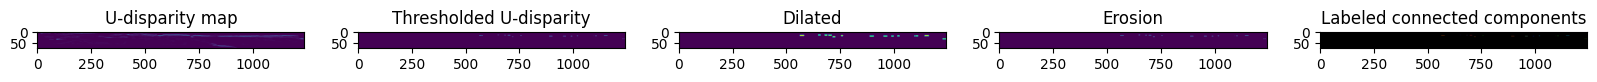

In [22]:
udisparity_gray = np.uint8(udisp)
# udisparity_gray = cv2.cvtColor(udisp, cv2.COLOR_BGR2GRAY)

# Apply threshold
ret, thresholded = cv2.threshold(udisparity_gray, 127, 255, cv2.THRESH_BINARY)

# Apply morphological operations
kernel = np.ones((5,5), np.uint8)
dilated = cv2.dilate(thresholded, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

# Label each distinct region (see connectedComponents)
num_labels, labels = cv2.connectedComponents(eroded)

# Color each region differently
labeled_udisparity = np.zeros((udisparity_gray.shape[0], udisparity_gray.shape[1], 3), dtype=np.uint8)
for i in range(1, num_labels):
    labeled_udisparity[labels == i] = np.random.randint(0, 256, 3)

# Display results
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes[0].set_title("U-disparity map")
axes[0].imshow(udisparity_gray)

axes[1].set_title("Thresholded U-disparity")
axes[1].imshow(thresholded)

axes[2].set_title("Dilated")
axes[2].imshow(dilated)

axes[3].set_title("Erosion")
axes[3].imshow(eroded)

axes[4].set_title("Labeled connected components")
axes[4].imshow(labeled_udisparity)

plt.show()

In [23]:
#Now, we're ready to go from U-disparity back to image space

#TO DO: we need to label the pixel from the original image with the label of the corresponding region from the U-disparity map
#(1) propagate labels from the U-disparity map to image space
#(2) try to separate each distinct region using the determined labels 
#    (remember the coins image from Image Processing (3rd year) and how we managed to separate and display each coin from the image, something similar we have to do here)
#(3) draw a bounding-box around each determined region and display the results, if the result is too noisy (small regions) try to filter the bounding-boxes 
#    (e.g. using area of rectangle and/or set a threshold for rectangle's width and height)
#(4) display the two results
#(5) answer the following questions:
#    Q1: how good are the reults of the U-disparity segmentation? Is the result obtained as good as expected?
#    Q2: a bounding-box has more than one object?
#    (tip: search the terms => undersegmentation, oversegmentation)

def uDisparitySegmentation(img, disp):
    # compute the U-disparity map
    udisp, udispHeight = uDisparity(disp, groundMask)

    # apply threshold to the U-disparity map
    threshold = 30
    udispThresh = cv2.threshold(udisp, threshold, 255, cv2.THRESH_BINARY)[1]

    # apply morphological operations to the thresholded U-disparity map
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    udispDilated = cv2.dilate(udispThresh, kernel, iterations=1)
    udispEroded = cv2.erode(udispDilated, kernel, iterations=1)

    # label the connected components in the U-disparity map
    numLabels, labeledImage = cv2.connectedComponents(udispEroded)

    # propagate labels from U-disparity to image space
    labels = np.zeros(img.shape[:2], dtype=np.uint8)
    for i in range(1, numLabels):
        mask = np.uint8(labeledImage == i)
        regionMask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        labels[regionMask > 0] = i

    # separate each distinct region using the determined labels
    regions = []
    for i in range(1, numLabels):
        mask = np.uint8(labeledImage == i)
        regionMask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        region = cv2.bitwise_and(img, img, mask=regionMask)
        regions.append(region)

    # draw bounding boxes around each determined region
    boxes = []
    for i in range(1, numLabels):
        mask = np.uint8(labeledImage == i)
        regionMask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        x,y,w,h = cv2.boundingRect(regionMask)
        if w*h > 1000 and w < 0.8*img.shape[1] and h < 0.8*img.shape[0]:
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
            boxes.append((x,y,w,h))

    # display the results
    cv2.imshow("Original Image", img)
    cv2.imshow("U-disparity Map", udisp)
    cv2.imshow("Thresholded U-disparity Map", udispThresh)
    cv2.imshow("Dilated U-disparity Map", udispDilated)
    cv2.imshow("Eroded U-disparity Map", udispEroded)
    cv2.imshow("Labeled Regions", np.uint8(labeledImage / numLabels * 255))
    cv2.imshow("Detected Regions", np.hstack(regions))

    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [24]:
def uDisparityToMask(disparity, uDispLabeled, udispHeight):
    dim = disparity.shape
    h = dim[0]
    w = dim[1]

    # remove ground pixels
    mask = np.zeros((h, w), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if disparity[i][j] != 0:
                v = udispHeight - disparity[i][j]
                label = uDispLabeled[v][j]
                mask[i][j] = label

    return mask


In [20]:
# Convert the U-disparity map to a mask
mask = uDisparityToMask(disparity, uDispLabeled, udispHeight)

# Propagate the labels to the image space
labels = np.zeros((h, w), dtype=np.uint8)
for i in range(h):
    for j in range(w):
        if mask[i][j] != 0:
            labels[i][j] = mask[i][j]

NameError: ignored

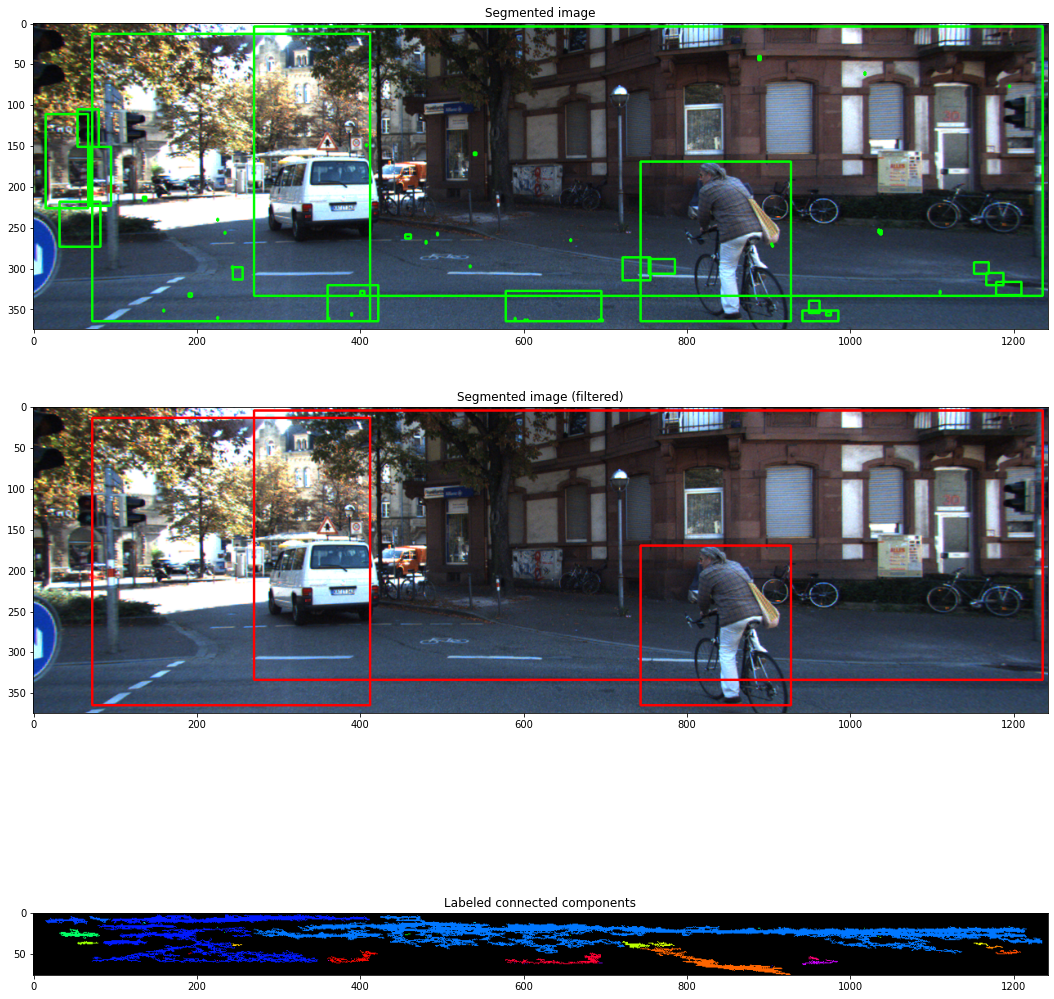

In [ ]:
#create copies of original image

regionsAll = #...
regionsFiltered = #...

#iterate through each label and draw a bounding-box for every segmented region
for i in range(1, num_labels): # 0 - represents background
  #isolate the region labeled with "i"
  #...

  #draw bounding-box around the region

  #compute bounding-box (rectangle) 
  #...

  #draw all bboxes
  #...

  #filter small bboxes
  #...
  #draw filtered bboxes


#display results: Segmented image (All bboxes), Segmented image (Filtered bboxes), Labeled U-disparity
#...


In [ ]:
#TO DO: remember the camera parameters for the KITTI dataset used last time and how we removed some information from the images based on depth?
#(1) try to change the implementation and compute the U-disparity map using the information within 15m or 25m (filter the image based on depth information)
#(2) does the output of the segmentation change? Explain how.

#### Ground-plane detection using V-disparity maps

In [ ]:
#until now we've used masks to filter ground-plane pixels
#let's move on and see how can we compute the ground plane using the V-disparity map
#Steps to compute ground-plane:
#(1) compute V-disparity map
#(2) apply Hough Transform to detect the lines from V-disparity
#(3) choose the best line
#(4) return to image space from V-disparity space and label all ground pixels

In [ ]:
#TO DO: (1) compute the V-disparity map using the formula from above
def vDisparity(disparity):
  dim = disparity.shape
  h = dim[0]
  w = dim[1]
 
  #compute max value
  #...

  #create zero mat to store V-disparity
  #...

  #compute V-disparity
  #...

  return vdisp, vdispWidth

In [ ]:
#compute V-disparity
vdisp, vdispWidth = #...

In [ ]:
def draw_lines(img, houghLines, color=[0, 255, 0], thickness=2):
    for line in houghLines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
 
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)   
 
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

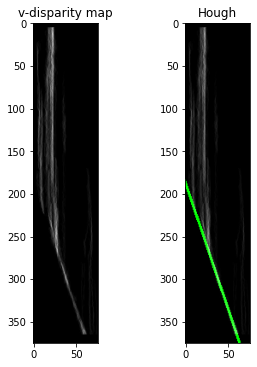

In [ ]:
#TO DO: (1) apply Hough Transform to detect the lines from the V-disparity (see Project 1 for Hough)
#(2) choose the best line after applying Hough (tip: try to filter the computed V-disparity before applying Hough)
#(3) display results

#filter the computed V-disparity before applying Hough
#...

#apply Hough
#...

#output Hough
#...


#display results: v-disparity map, Hough
#...

In [ ]:
#Now, we're ready to go from V-disparity back to image space

#TO DO: we need to label the ground pixel from the original image using the computed line
#(1) propagate line pixels from the V-disparity map to image space
 
def vDisparityToMask(disparity, hough_lines_image, vdispWidth):
  dim = disparity.shape
  h = dim[0]
  w = dim[1]
 
  #create zero mat to store the mask
  #...

  
  
  #compute mask
  #...

  return mask

In [ ]:
groundMask = #...

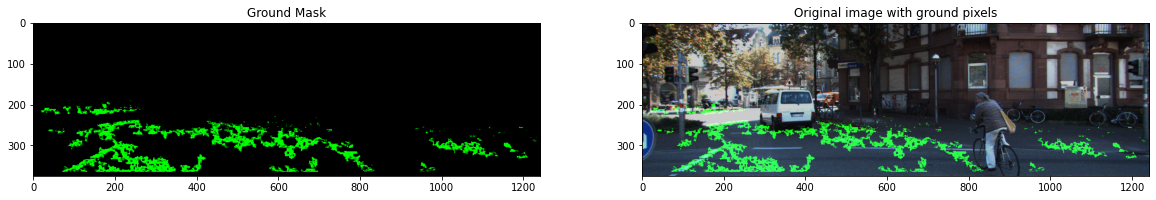

In [ ]:
#TO DO: (1) display the results: the ground mask and the ground mask overlayed on the original image
#(2) compare the computed mask with the ground mask available from the dataset
#(3) answer the following questions:
#    Q1: how good are the results (ground mask)?
#    Q2: how could we improve the result? 


#display result: Ground Mask, Original image with ground pixels
#...